# **Predicting Loan Sanction Status using Neural Network**

I am stepping into Deep Learning for the first time. I thought of building a classifier using Keras. In order to go through the full ML experience, I chose an unpopular dataset from Kaggle Datasets. Handled data viz and preprocessing, then built a Sequential NN model. It may seem unnecessary to use Neural Network for numerical prediction, but I would like to see if Deep Learning can perform well in these prediction tasks.

Dataset source: Loan_data (https://www.kaggle.com/pallavi31/loan-data)

Dataset owner: Pallavi Vibhute (https://www.kaggle.com/pallavi31)


In [1]:
# Importing necessary modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
train = pd.read_csv('../input/loan-data/Loan_Training_data.csv')
test = pd.read_csv('../input/loan-data/Loan_Test_Data.csv')

In [3]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


So, our training data has shape of (614, 13). The last column, Loan_Status, will be our target label.

It has two classes: 'Y' for sanctioned loans & 'N' for rejected loan applications

Most of the other columns are self-explanatory. 'Loan_Amount_Term' is the number of months within which the loan should be repaid; 'Credit_History' has values 1.0 if the applicant has credit history and 0.0 if they do not; 'Property_Area tells' us the category of location of the collateral property which is provided as security for the loan.

# **Data Visualization**

In [4]:
train.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

The value counts of the label shows that we have an imbalanced dataset. Most ML models do not work well with imbalanced datasets. To tackle this, we can either collect more data or add synthetic data using popular tools like SMOTE or sklearn.utils.resample. 


In [5]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

We have a lot of null values in various columns. Since our training dataset is small, dropping rows is not a viable solution. So, I am gonna replace the null values of a feature with the most frequent value of that feature. We will see that in the preprocessing part.

Text(0.5, 1.0, 'Loan Amount vs Gender - grouped based on Loan Status')

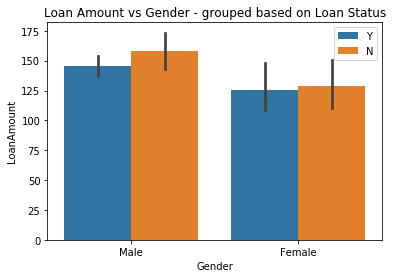

In [6]:
sns.barplot(train.Gender, train.LoanAmount, hue=train.Loan_Status)
plt.legend(loc='upper right')
plt.title('Loan Amount vs Gender - grouped based on Loan Status')

This plot tells us that male applicants are lent a larger amount compared to female applicants. But the sanction-to-rejection ratio is higher for female applicants than to that of male applicants.

Text(0.5, 1.0, 'Loan Amount vs Gender - grouped based on Marital Status')

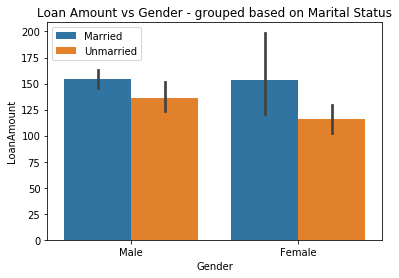

In [7]:
# Changing categorical names for the sake of easier understanding
train.Married = train.Married.apply(lambda x: 'Married' if x == 'Yes' else 'Unmarried')

sns.barplot(train.Gender, train.LoanAmount, hue=train.Married, hue_order = ['Married', 'Unmarried'])
plt.legend(loc='upper left')
plt.title('Loan Amount vs Gender - grouped based on Marital Status')

But when it comes to marital status, both men and women can get equal loans when they are married.

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 <a list of 11 Text xticklabel objects>)

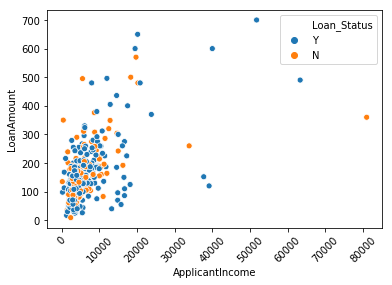

In [8]:
sns.scatterplot(train.ApplicantIncome, train.LoanAmount, hue=train.Loan_Status)
plt.xticks(rotation=45)

There is no discernible correlation between Applicant's Income and the Loan Amount. But the scatter plot shows that most of the applicants are people with low-income and the chance of getting a loan does not depend on the applicant's income.

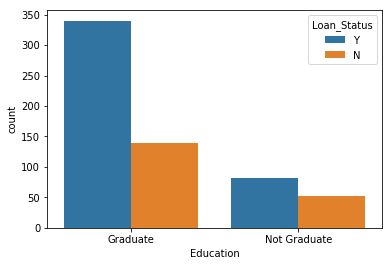

In [9]:
sns.countplot(train.Education, hue=train.Loan_Status)

Not so surprisingly, people with graduate degree have a higher chance of getting a loan than the applicant's without one.

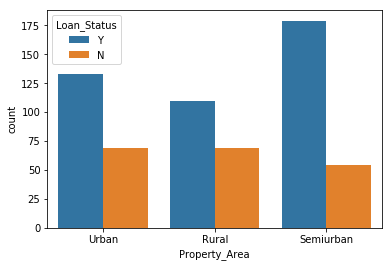

In [10]:
sns.countplot(train.Property_Area, hue=train.Loan_Status)

Surprisingly, property in semi-urban areas render a higher chance of loan sanction than others. This might be due to the fact that semi-urban areas call for more reconstructional capabilities than the urban areas. A semi-urban area is a lot easier to remodel and build than an urban area. And as expected, rural areas score the least here.

Next, for a full scale visualization, I am employing the pairplot from seaborn.

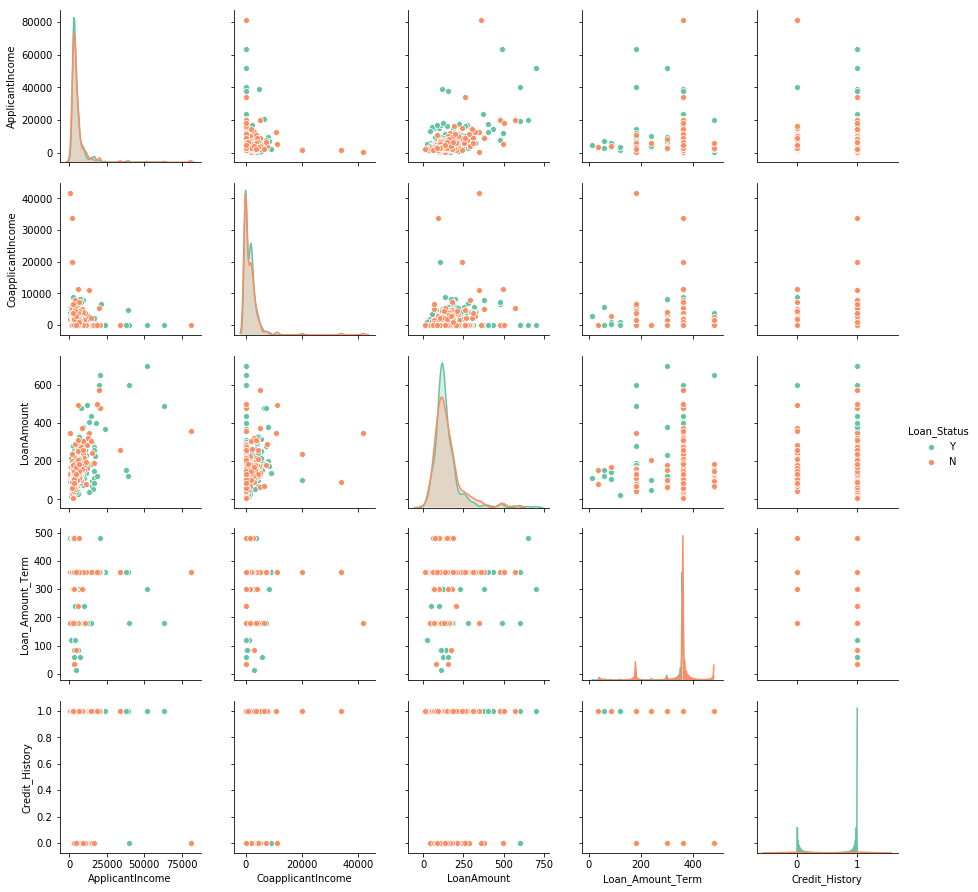

In [11]:
sns.pairplot(train, hue='Loan_Status', palette='Set2', diag_kind='kde')

There are some interesting things going on here:
1. As already stated, Applicant's Income does not determine the loan sanction status (plot - row 1, col 1).
2. But, applicants having credit history have a higher chance of getting a loan (plot - row 5 col 5).
3. Applicants with higher income **and** credit history have a higher chance of getting a loan (plot row 1 col 5).
4. Loan Amount KDE (plot - row 3 col 3) peaks around 150 for both sanctioned and rejected loans, with sanctioned overpowering
   rejected. Beyond the peak, more loan amount invites more rejected applications than sanctioned ones.

Bottomline from these plots: You have a higher chance of getting a loan if you are a **Married Male Graduate having a Property in Semi-Urban area**.

Now, the preprocessing part.

# **Data Preprocessing**

Step 1 is to split the dataset into features and target.

In [12]:
def target_split(train): 
    train_mod = train[~train['LoanAmount'].isnull()] # Loan Amount has few null values but they should not be imputed
    train_mod.drop('Loan_ID', axis = 1, inplace=True) # Dropping ID column as it is not relevant to the model

    y = train_mod.Loan_Status
    train_mod.drop('Loan_Status', axis = 1, inplace=True)

    y = y.apply(lambda x: 1 if x == 'Y' else 0) # Changing categories to numerical values
    
    return train_mod, y

Next step is to fill the null values.

In [13]:
def impute(train):
    cols = train.columns
    nan_cols = []
    for col in cols:
        if(train[col].isnull().sum() > 0):
            nan_cols.append(col)
    # nan_cols contains the list of columns having null values
    
    argmax_in_nan = {}
    for col in nan_cols:
        argmax_in_nan[col] = None
        argmax_in_nan[col] = train[col].value_counts().idxmax() # Getting the most frequent value in the column
        
        train[col].fillna(argmax_in_nan[col], inplace=True)
            
    return train

After filling null values, comes the normalization part. MinMaxScaler maps the values to values in range [0,1]. 

In [14]:
def scaler(train):
    num_cols = [col for col in train.select_dtypes(exclude='object').columns]
    scaler = MinMaxScaler()
    for col in num_cols:
        if (col != 'Credit_History'): # Credit_History belongs to int64 datatype but it is a categorical value. So it should not be scaled.
            train[col] = scaler.fit_transform(train[[col]])
            
    return train

Now, to handle the categorical variables, I am using get_dummies function from pandas. This will create a column for each categorical variable under each feature

In [15]:
def cat_enc(train):
    cat_cols = [col for col in train.select_dtypes(include='object').columns]
    
    for col in cat_cols:
        dummies = pd.get_dummies(train[col], prefix=col)
        train = pd.concat([train,dummies], axis=1)
        train.drop([col],axis = 1 , inplace=True)
    
    return train

Compiling all the above steps, this function renders a ML-ready dataset.

In [16]:
def preprocess(train):
    train, y = target_split(train)
    train = impute(train)
    train = scaler(train)
    train = cat_enc(train)
    
    return train, y

In [17]:
train_mod, y = preprocess(train)

In [18]:
train_mod.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_Married,Married_Unmarried,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,0.054830,0.036192,0.172214,0.74359,1.0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0
2,0.035250,0.000000,0.082489,0.74359,1.0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1
3,0.030093,0.056592,0.160637,0.74359,1.0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1
4,0.072356,0.000000,0.191027,0.74359,1.0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1
5,0.065145,0.100703,0.373372,0.74359,1.0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1


After dropping rows with null LoanAmount and preprocessing, the training data has shape of (592, 20)

# **Model development**

I'm using keras module to build the neural network. I'm going for a wider, shallow network rather than a narrow deeper one. Adam is currently the most popular optimizer. I'm printing the accuracy score of the model at every epoch.

In [19]:
np.random.seed(0)

model = Sequential()

model.add(Dense(48, kernel_initializer='normal',input_dim = train_mod.shape[1], activation='relu'))
model.add(Dense(96, kernel_initializer='normal',activation='relu'))
model.add(Dense(96, kernel_initializer='normal',activation='relu'))

model.add(Dense(1, kernel_initializer='normal',activation='linear'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 48)                1008      
_________________________________________________________________
dense_2 (Dense)              (None, 96)                4704      
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 97        
Total params: 15,121
Trainable params: 15,121
Non-trainable params: 0
_________________________________________________________________


Here, I am using a checkpoint list to store the weights of the model when it performs the best. By this method, I can reuse the best weights for the test data.

The filename stores the epoch number along with the validation loss at that epoch (it is useful in the coming part). I specified the model to use log_loss
After training the model, the weights file with the least validation loss will be selected for predicting.

In [20]:
checkpoint_name = 'Weights-{epoch:02d}--{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [21]:
model.fit(train_mod, y, epochs=50, batch_size=37, validation_split = 0.2, callbacks=callbacks_list)

Train on 473 samples, validate on 119 samples
Epoch 1/50
473/473 [==============================] - 1s 1ms/step - loss: 2.7288 - acc: 0.3066 - val_loss: 1.5432 - val_acc: 0.3025

Epoch 00001: val_loss improved from inf to 1.54316, saving model to Weights-01--1.54.hdf5
Epoch 2/50
473/473 [==============================] - 0s 67us/step - loss: 1.1402 - acc: 0.3066 - val_loss: 0.7427 - val_acc: 0.3193

Epoch 00002: val_loss improved from 1.54316 to 0.74271, saving model to Weights-02--0.74.hdf5
Epoch 3/50
473/473 [==============================] - 0s 51us/step - loss: 0.6461 - acc: 0.6448 - val_loss: 0.6225 - val_acc: 0.6975

Epoch 00003: val_loss improved from 0.74271 to 0.62245, saving model to Weights-03--0.62.hdf5
Epoch 4/50
473/473 [==============================] - 0s 51us/step - loss: 0.5963 - acc: 0.6956 - val_loss: 0.5897 - val_acc: 0.6975

Epoch 00004: val_loss improved from 0.62245 to 0.58970, saving model to Weights-04--0.59.hdf5
Epoch 5/50
473/473 [===========================

473/473 [==============================] - 0s 48us/step - loss: 0.4156 - acc: 0.8118 - val_loss: 0.8161 - val_acc: 0.8319

Epoch 00042: val_loss did not improve from 0.50216
Epoch 43/50
473/473 [==============================] - 0s 47us/step - loss: 0.4154 - acc: 0.8140 - val_loss: 0.7058 - val_acc: 0.8151

Epoch 00043: val_loss did not improve from 0.50216
Epoch 44/50
473/473 [==============================] - 0s 46us/step - loss: 0.4231 - acc: 0.8118 - val_loss: 0.8233 - val_acc: 0.8319

Epoch 00044: val_loss did not improve from 0.50216
Epoch 45/50
473/473 [==============================] - 0s 47us/step - loss: 0.4101 - acc: 0.8140 - val_loss: 1.0272 - val_acc: 0.8319

Epoch 00045: val_loss did not improve from 0.50216
Epoch 46/50
473/473 [==============================] - 0s 47us/step - loss: 0.4029 - acc: 0.8161 - val_loss: 0.9188 - val_acc: 0.8151

Epoch 00046: val_loss did not improve from 0.50216
Epoch 47/50
473/473 [==============================] - 0s 46us/step - loss: 0.4097

In [22]:
!ls .

Weights-01--1.54.hdf5  Weights-05--0.57.hdf5  Weights-09--0.53.hdf5
Weights-02--0.74.hdf5  Weights-06--0.56.hdf5  Weights-21--0.52.hdf5
Weights-03--0.62.hdf5  Weights-07--0.55.hdf5  Weights-23--0.50.hdf5
Weights-04--0.59.hdf5  Weights-08--0.54.hdf5  __notebook_source__.ipynb


The ls command shows the checkpoints at which the model has the highest accuracy. The files contain the weights for that particular epoch (the two digit number after *Weights-*). 

So, in this part, I had a problem. Each time I run this kernel, the name of weight file with best weights change. While committing, the filename changes and throws an error in final kernel. Hence, I could not specify one particular filename when loading weights. So, I wrote a piece of code where I check for the filename with lowest validation loss. I used that file in load_weights function.

In [23]:
import os

best_weight_file = str()
val_loss = 100
for filename in os.listdir():
    if(filename.startswith('W')):
        name, ext = os.path.splitext(filename)
        if(int(name[-2:]) < val_loss):
            val_loss = int(name[-2:])
            best_weight_file = filename
            
print(best_weight_file)

Weights-23--0.50.hdf5


In [24]:
model.load_weights(best_weight_file)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

scores = model.evaluate(train_mod, y, verbose=0)
print("Accuracy of model: %.2f%%" % (scores[1]*100))

Accuracy of model: 82.09%


The overall model gave 82.09% accuracy on training data, which is pretty decent for a shallow neural network.

# Conclusion

In this kernel, I chose a random problem and built a decent classifier using a shallow neural network. I was able to tackle the problems I faced. If you have any questions or suggestions to improve the kernel, you are welcome to say it.